# Calcul du nombre de prélèvements CVM non conforme par commune et par année

L'objectif de ce notebook est de partir de la liste de communes cog_communes, et pour chaque commune et chaque année, calculer le nombre de prélèvements non conformes pour le CVM.

Il y aura plusieurs aggrégations à faire :

- commune (inseecommune) peut avoir plusieurs UDIs (cdreseau) **ET** un UDI peut avoir plusieurs communes (inseecommune) 
- un prélèvement (referenceprel) peut être rattaché à plusieurs UDIs (cdreseau)
- un prélèvement (referenceprel) peut être composé de plusieurs paramètres (cdparametresiseeaux) ; mais dans le cas du CVM, il y a un seul paramètre selon la catégorisation de Pauline, donc c'est plus simple




In [1]:
%load_ext sql
%sql duckdb:///../../database/data.duckdb
%config SqlMagic.displaylimit = 10

The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Connecting to 'duckdb:///../../database/data.duckdb'

In [2]:
%%sql
SELECT * FROM int__resultats_udi_communes
LIMIT 5

Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

referenceprel,cdparametresiseeaux,valtraduite,limitequal,de_partition,limitequal_float,unite,categorie,cdreseau,inseecommune,datetimeprel
00400121459,CHINE,0.000,"<=0,1 µg/L",2020,0.10000000149011612,µg/L,pesticides,004000129,04058,2020-04-09 11:49:00
00400121459,CHINOME,0.000,"<=0,1 µg/L",2020,0.10000000149011612,µg/L,pesticides,004000129,04058,2020-04-09 11:49:00
00400121459,CHLORB,0.000,"<=0,1 µg/L",2020,0.10000000149011612,µg/L,pesticides,004000129,04058,2020-04-09 11:49:00
00400121459,CHLPM,0.000,"<=0,1 µg/L",2020,0.10000000149011612,µg/L,pesticides,004000129,04058,2020-04-09 11:49:00
00400121459,CHLX,0.000,"<=0,1 µg/L",2020,0.10000000149011612,µg/L,pesticides,004000129,04058,2020-04-09 11:49:00


**Pour le cas dernier prélèvement**
    
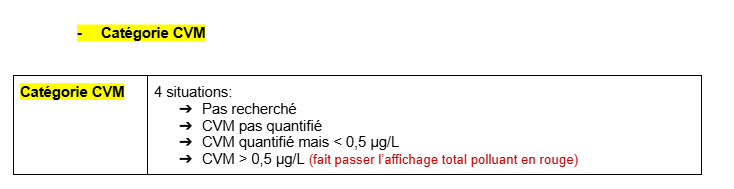

pour le cas "pas qunatifié"

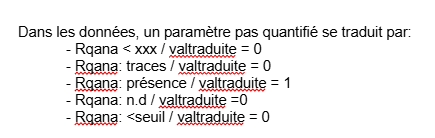

## Les résultats par communes - Last prelevement 

In [3]:
%%sql --save int__resultats_cvm_udi_dernier
WITH
last_pvl AS (
    SELECT
        cdreseau,
        categorie,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        limitequal_float,
        ROW_NUMBER()
            OVER (
                PARTITION BY cdreseau, cdparametresiseeaux
                ORDER BY datetimeprel DESC
            )
            AS row_number
    FROM
        int__resultats_udi_communes
    WHERE
        categorie = 'cvm' -- à supprimer pour avoir pour tout
        AND
        -- On garde les prélèvements de moins d'un an
        CURRENT_DATE - datetimeprel < INTERVAL 1 YEAR
)

SELECT
    last_pvl.cdreseau,
    last_pvl.categorie,
    last_pvl.cdparametresiseeaux,
    last_pvl.datetimeprel AS last_datetimeprel,
    'dernier prélévement' AS periode,
    CASE
        WHEN
            last_pvl.valtraduite = 0
            OR last_pvl.valtraduite IS NULL
            OR last_pvl.limitequal_float IS NULL
            THEN 'non quantifié'
        WHEN
            last_pvl.valtraduite >= last_pvl.limitequal_float
            THEN '>= 0,5 µg/L'
        WHEN
            last_pvl.valtraduite < last_pvl.limitequal_float
            THEN '< 0,5 µg/L'
        ELSE 'Check SQL'
    END AS resultat
FROM
    last_pvl
WHERE
    last_pvl.row_number = 1


Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

cdreseau,categorie,cdparametresiseeaux,last_datetimeprel,periode,resultat
033002231,cvm,CLVYL,2024-12-23 09:45:00,dernier prélévement,non quantifié
033002236,cvm,CLVYL,2024-12-23 09:45:00,dernier prélévement,non quantifié
034000083,cvm,CLVYL,2024-06-20 13:43:00,dernier prélévement,"< 0,5 µg/L"
034000437,cvm,CLVYL,2024-09-10 11:34:00,dernier prélévement,non quantifié
034000519,cvm,CLVYL,2024-08-29 10:17:00,dernier prélévement,"< 0,5 µg/L"
034000648,cvm,CLVYL,2024-08-20 14:28:00,dernier prélévement,non quantifié
034000658,cvm,CLVYL,2024-09-25 11:42:00,dernier prélévement,non quantifié
034000708,cvm,CLVYL,2024-10-24 11:14:00,dernier prélévement,non quantifié
034000800,cvm,CLVYL,2024-08-05 11:52:00,dernier prélévement,non quantifié
034001613,cvm,CLVYL,2024-09-11 09:52:00,dernier prélévement,"< 0,5 µg/L"


In [4]:
%%sql --with int__resultats_cvm_udi_dernier
SELECT DISTINCT
    resultat, MAX(cdreseau), MIN(cdreseau)
FROM
    int__resultats_cvm_udi_dernier
GROUP BY 
    1

Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

resultat,max(cdreseau),min(cdreseau)
">= 0,5 µg/L",087003637,001001073
non quantifié,976003489,001000241
"< 0,5 µg/L",095004048,001000235


# Check

**cdreseau = 976003489**

In [5]:
%%sql
 SELECT 
    *
 FROM
   int__resultats_udi_communes
WHERE
    cdreseau = '976003489'
    AND categorie = 'cvm'
    AND de_partition = '2024'
ORDER BY 
    datetimeprel DESC


Running query in 'duckdb:///../../database/data.duckdb'

referenceprel,cdparametresiseeaux,valtraduite,limitequal,de_partition,limitequal_float,unite,categorie,cdreseau,inseecommune,datetimeprel
97600031910,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,976003489,97604,2024-07-16 08:30:00
97600031910,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,976003489,97609,2024-07-16 08:30:00
97600031910,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,976003489,97606,2024-07-16 08:30:00
97600031910,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,976003489,97603,2024-07-16 08:30:00


On a plusieurs fois la même ligne avec inseecommune commune différent

In [6]:
%%sql --with int__resultats_cvm_udi_dernier 
 SELECT 
   *
 FROM
   int__resultats_cvm_udi_dernier
WHERE
    cdreseau = '976003489'
    AND categorie = 'cvm'

Running query in 'duckdb:///../../database/data.duckdb'

cdreseau,categorie,cdparametresiseeaux,last_datetimeprel,periode,resultat
976003489,cvm,CLVYL,2024-07-16 08:30:00,dernier prélévement,non quantifié


On a bien la bonne valeur

**cdreseau = 001000241**

In [7]:
%%sql
 SELECT 
    *
 FROM
   int__resultats_udi_communes
WHERE
    cdreseau = '001000241'
    AND categorie = 'cvm'
    AND de_partition = '2024'
ORDER BY 
    datetimeprel DESC

Running query in 'duckdb:///../../database/data.duckdb'

referenceprel,cdparametresiseeaux,valtraduite,limitequal,de_partition,limitequal_float,unite,categorie,cdreseau,inseecommune,datetimeprel
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01406,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01439,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01305,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01050,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01139,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01102,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01323,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01175,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01380,2024-12-31 14:00:00
00100143522,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,001000241,01437,2024-12-31 14:00:00


In [8]:
%%sql --with int__resultats_cvm_udi_dernier 
 SELECT 
   *
 FROM
   int__resultats_cvm_udi_dernier
WHERE
    cdreseau = '001000241'
    AND categorie = 'cvm'

Running query in 'duckdb:///../../database/data.duckdb'

cdreseau,categorie,cdparametresiseeaux,last_datetimeprel,periode,resultat
001000241,cvm,CLVYL,2024-12-31 14:00:00,dernier prélévement,non quantifié


**cdreseau = 087003637**

In [9]:
%%sql
 SELECT 
    *
 FROM
   int__resultats_udi_communes
WHERE
    cdreseau = '087003637'
    AND categorie = 'cvm'
    AND de_partition = '2024'
ORDER BY 
    datetimeprel DESC

Running query in 'duckdb:///../../database/data.duckdb'

referenceprel,cdparametresiseeaux,valtraduite,limitequal,de_partition,limitequal_float,unite,categorie,cdreseau,inseecommune,datetimeprel
08700121168,CLVYL,0.580,<=0.5 µg/L,2024,0.5,µg/L,cvm,087003637,87178,2024-07-04 10:50:00


In [10]:
%%sql --with int__resultats_cvm_udi_dernier 
 SELECT 
   *
 FROM
   int__resultats_cvm_udi_dernier
WHERE
    cdreseau = '087003637'
    AND categorie = 'cvm'

Running query in 'duckdb:///../../database/data.duckdb'

cdreseau,categorie,cdparametresiseeaux,last_datetimeprel,periode,resultat
087003637,cvm,CLVYL,2024-07-04 10:50:00,dernier prélévement,">= 0,5 µg/L"


**cdreseau = 095004048**

In [11]:
%%sql
 SELECT 
    *
 FROM
   int__resultats_udi_communes
WHERE
    cdreseau = '095004048'
    AND categorie = 'cvm'
    AND de_partition = '2024'
ORDER BY 
    datetimeprel DESC

Running query in 'duckdb:///../../database/data.duckdb'

referenceprel,cdparametresiseeaux,valtraduite,limitequal,de_partition,limitequal_float,unite,categorie,cdreseau,inseecommune,datetimeprel
09500180358,CLVYL,0.004,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95277,2024-07-23 08:26:00
09500180358,CLVYL,0.004,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95019,2024-07-23 08:26:00
09500180358,CLVYL,0.004,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95268,2024-07-23 08:26:00
09500181157,CLVYL,0.005,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95277,2024-07-03 09:28:00
09500181157,CLVYL,0.005,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95019,2024-07-03 09:28:00
09500181157,CLVYL,0.005,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95268,2024-07-03 09:28:00
09500179740,CLVYL,0.006,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95277,2024-06-21 08:51:00
09500179740,CLVYL,0.006,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95019,2024-06-21 08:51:00
09500179740,CLVYL,0.006,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95268,2024-06-21 08:51:00
09500179711,CLVYL,0.000,<=0.5 µg/L,2024,0.5,µg/L,cvm,095004048,95277,2024-06-20 08:55:00


In [12]:
%%sql --with int__resultats_cvm_udi_dernier 
 SELECT 
   *
 FROM
   int__resultats_cvm_udi_dernier
WHERE
    cdreseau = '095004048'
    AND categorie = 'cvm'

Running query in 'duckdb:///../../database/data.duckdb'

cdreseau,categorie,cdparametresiseeaux,last_datetimeprel,periode,resultat
095004048,cvm,CLVYL,2024-07-23 08:26:00,dernier prélévement,"< 0,5 µg/L"
